In [1]:
import jaxsp as jsp

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

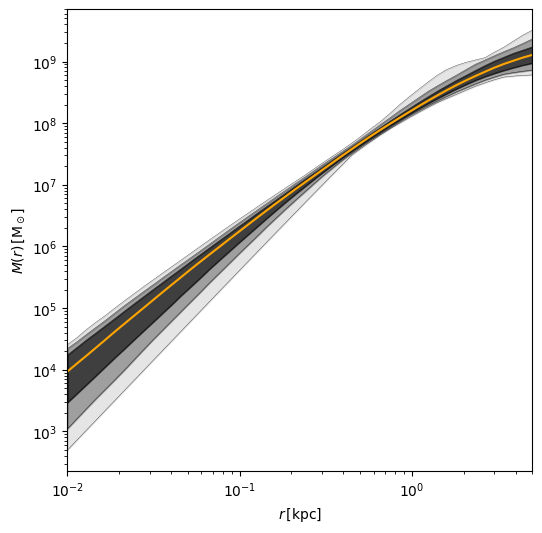

In [2]:
mass_data = np.loadtxt('data/leoii.txt')
fig = plt.figure(figsize=(6, 6))
for i in range(1, 8):
    plt.loglog(mass_data[:, 0], mass_data[:, i], lw=0.2, c='k')
plt.loglog(mass_data[:, 0], mass_data[:, 1], lw=1.5, c='orange')
plt.fill_between(mass_data[:, 0], mass_data[:, 2], mass_data[:, 3], alpha=0.6, color='k')
plt.fill_between(mass_data[:, 0], mass_data[:, 4], mass_data[:, 5], alpha=0.3, color='k')
plt.fill_between(mass_data[:, 0], mass_data[:, 6], mass_data[:, 7], alpha=0.1, color='k')
plt.xlim(1e-2, 5e0)
plt.xlabel(r'$r\,\mathrm{[kpc]}$')
plt.ylabel(r'$M(r)\,\mathrm{[M_\odot]}$')
plt.show()

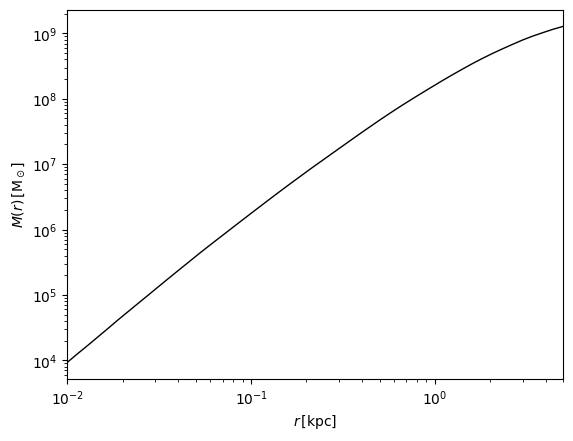

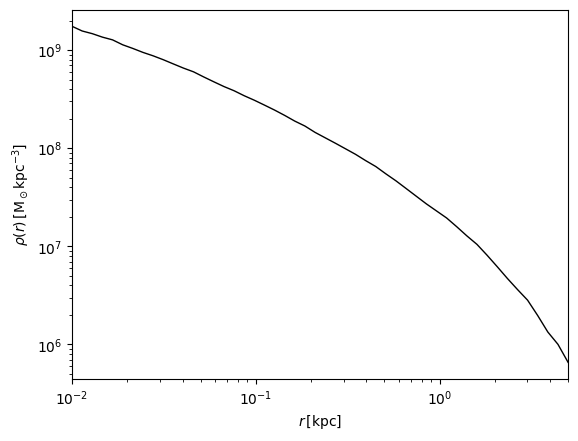

In [3]:
mass = jsp.MassProfile(mass_data)
density = jsp.DensityProfile(mass)
mass.plot()
density.plot()

Pre-compilation
CPU times: user 261 ms, sys: 3.96 ms, total: 265 ms
Wall time: 108 ms
CPU times: user 200 ms, sys: 4.56 ms, total: 205 ms
Wall time: 193 ms

Post-compilation
39.2 µs ± 172 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
71.2 µs ± 721 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


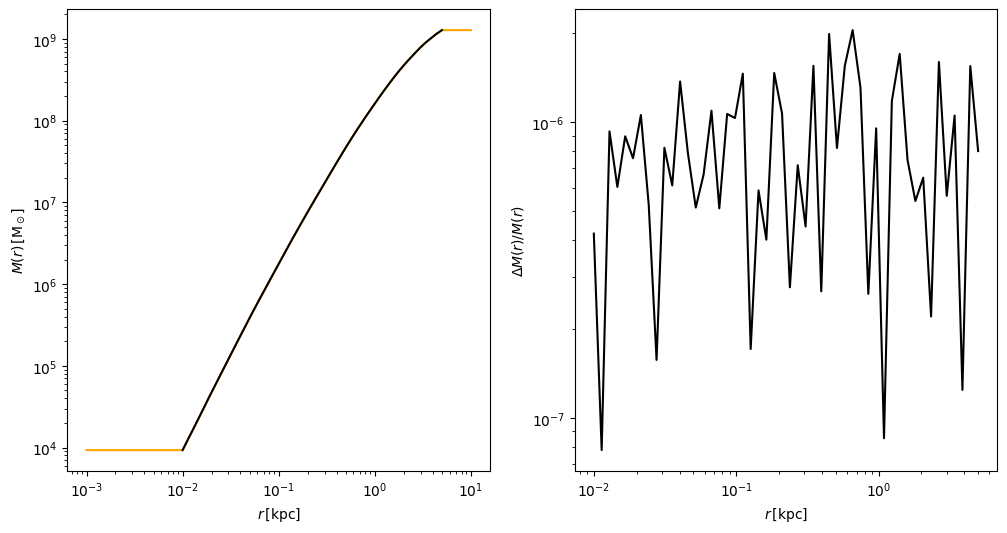

In [4]:
mass = jsp.MassProfile(mass_data)
density = jsp.DensityProfile(mass)
rkpc = jnp.logspace(-3, 1, 1000)
print("Pre-compilation")
%time mass(rkpc)
%time density(rkpc)
print("\nPost-compilation")
%timeit mass(rkpc)
%timeit density(rkpc)
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1)
plt.loglog(rkpc, mass(rkpc), c='orange')
plt.loglog(mass_data[:, 0], mass_data[:, 1], c='k')
plt.xlabel(r'$r\,\mathrm{[kpc]}$')
plt.ylabel(r'$M(r)\,\mathrm{[M_\odot]}$')
ax = plt.subplot(1, 2, 2)
plt.loglog(mass_data[:, 0], jnp.abs((mass(mass_data[:, 0]) - mass_data[:, 1])/mass_data[:, 1]), c='k')
plt.xlabel(r'$r\,\mathrm{[kpc]}$')
plt.ylabel(r'$\Delta M(r)/M(r)$')
plt.show()

CPU times: user 179 ms, sys: 3.45 ms, total: 183 ms
Wall time: 174 ms
CPU times: user 163 ms, sys: 3.57 ms, total: 166 ms
Wall time: 157 ms
CPU times: user 405 µs, sys: 71 µs, total: 476 µs
Wall time: 477 µs


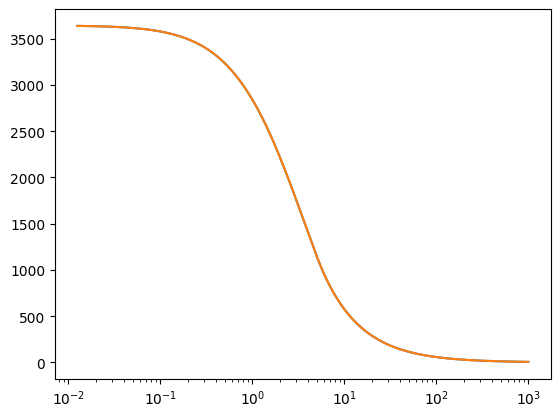

In [5]:
rkpc = jnp.logspace(-1.9, 3, 1000)
potential = jsp.GravPotential(mass, rpts=1000)
%time potential(rkpc)
plt.semilogx(rkpc, -potential(rkpc))
potential._cache()
%time potential(rkpc)
%time potential(rkpc)
plt.semilogx(rkpc, -potential(rkpc))

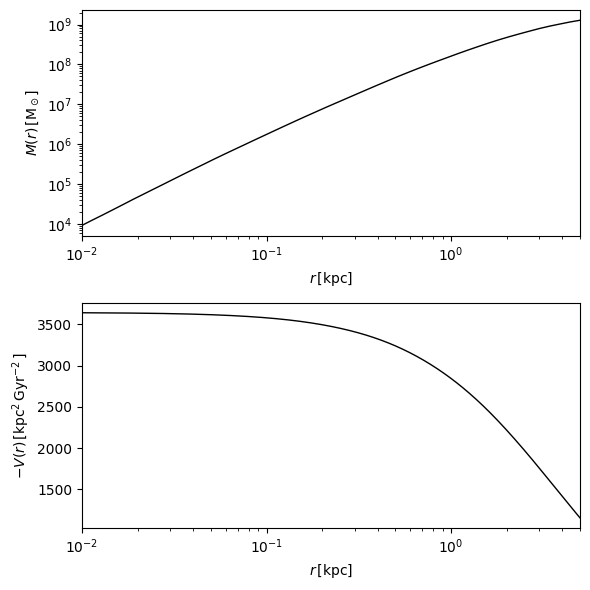

GravPotential(
	rmin=0.01 kpc, 
	rmax=5.0 kpc, 
	npoints=1000, 
	cached=True, 
	mass=MassProfile(rmin=0.01 kpc, max=5.0 kpc, npoints=50))
)

In [6]:
potential = jsp.GravPotential(mass, rpts=1000)
potential.plot()
potential

Pre-compilation
CPU times: user 655 ms, sys: 12.2 ms, total: 667 ms
Wall time: 637 ms
Post-compilation
660 µs ± 64.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Schrodinger(
	potential=GravPotential(
	rmin=0.01 kpc, 
	rmax=5.0 kpc, 
	npoints=1000, 
	cached=True, 
	mass=MassProfile(rmin=0.01 kpc, max=5.0 kpc, npoints=50))
), 
	ma=2e-22 eV, 
	Emin=-617.8196411132812 kg nm^2 / Gyr^2, 
	Emax=-391.57342529296875 kg nm^2 / Gyr^2
)

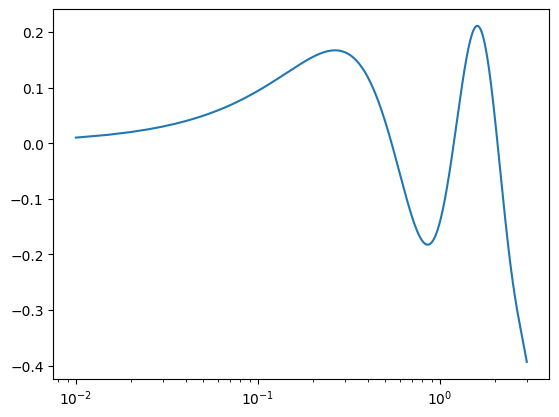

In [7]:
mass = jsp.MassProfile(mass_data)
potential = jsp.GravPotential(mass)
schrodinger = jsp.Schrodinger(ma=2e-22, potential=potential)
print("Pre-compilation")
%time solution = schrodinger.schrodinger_solver(0, schrodinger.Emin, rmax=2.)
print("Post-compilation")
%timeit solution = schrodinger.schrodinger_solver(0, schrodinger.Emin)
rkpc = jnp.linspace(schrodinger.potential.rmin, schrodinger.potential.rmax, 1000)
solution = schrodinger.schrodinger_solver(0, schrodinger.Emin, rmax=3.)
plt.semilogx(rkpc, jax.vmap(solution.evaluate)(rkpc)[:, 0])
schrodinger

(-1.0, 1.0)

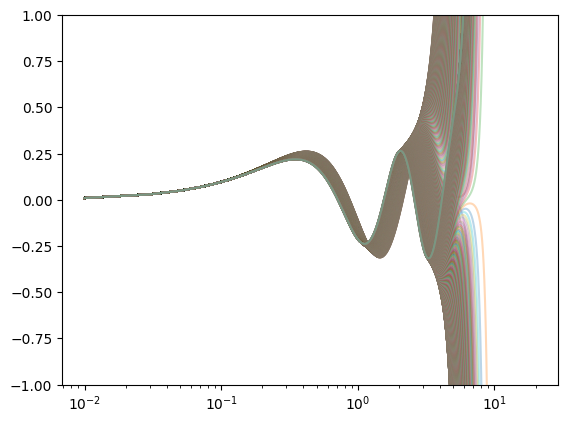

In [8]:
schrodinger = jsp.Schrodinger(1.3e-22, potential)
rmax = 20.
for E in jnp.linspace(schrodinger.Emin, schrodinger.Emax, 1000):    
    solution = schrodinger.schrodinger_solver(0, E, rmax=rmax)
    rk = jnp.linspace(schrodinger.potential.rmin, rmax, 1000)
    plt.semilogx(rk, jax.vmap(solution.evaluate)(rk)[:, 0], alpha=0.3)
plt.ylim(-1., 1.)

In [9]:
uldm_mass = jsp.ma(value=1e-22)
print("Compton wavelength: ", uldm_mass.compton_wavelength)
print("Length scale from potential: ", uldm_mass.length_scale(potential_kpc_Gyr=-1000.))

Compton wavelength:  0.0004018054193018054 kpc
Length scale from potential:  3.895739793777466 kpc
